In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
import pickle
import corner
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

import torch
from torch import nn, Tensor, optim, FloatTensor
from torch.distributions import MultivariateNormal
from geomloss import SamplesLoss
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

os.chdir('/scratch/gpfs/jiaxuanl/Data/popsed/')
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.speculator import SuperSpeculator, StandardScaler
import popsed
from popsed import prior
import gc

Input parameters : logmstar, kappa1_sfh, kappa2_sfh, kappa3_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index, redshift


**Input parameters : logmstar, InvSigmoid(kappa1_sfh), InvSigmoid(kappa2_sfh), InvSigmoid(kappa3_sfh), log10(fburst), log10(tburst), logzsol, log10(dust1), log10(dust2), dust_index, log10(redshift)**

We still need penalty on logzsol and dust_index

(10 params)

beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh = Transform(kappa1_sfh, kappa2_sfh, kappa3_sfh)

### Try to test how kappa transforms into beta

In [29]:
from popsed.nde import _inv_beta_cdf, _beta_cdf
def gen_truth(N_samples=5000):
    ncomp = 4
    priors = prior.load_priors([
            # flat dirichilet priors for SFH
            prior.TruncatedNormalPrior(0, 1, 0.5, 0.6),
            prior.UniformPrior(0., 1.,),
            prior.UniformPrior(0., 1.,),
            # uniform priors on the mass fraction of burst
            prior.TruncatedNormalPrior(0, 1, 0.1, 0.7, label='fburst'),
            # uniform priors on star-burst lookback time
            prior.TruncatedNormalPrior(1e-2, 13.27, 12, 7, label='tburst'),
            # uniform priors on log-metallicity, absolute Z
#             prior.UniformPrior(-2.6, 0.3, label='logzsol'),
            prior.TruncatedNormalPrior(-2.6, 0.3, -1.2, 0.9, label='logzsol'),
            # uniform priors on dust1
#             prior.UniformPrior(0., 3., label='dust1'),
            prior.TruncatedNormalPrior(0., 3., 1, 0.8, label='dust1'),
            # uniform priors on dust2
#             prior.BiGaussianPrior([0.3, 1.0], [[0.02, 0], [0, 0.05]], p1=0.3, label='dust2'),
            prior.TruncatedNormalPrior(0., 3., 0.6, 0.8, label='dust2'),
            # uniform priors on dust_index
            prior.TruncatedNormalPrior(-3., 1., 2, 2, label='dust_index'),
            # uniformly sample redshift
#             prior.TruncatedNormalPrior(0, 0.78, 0.18, 0.1, label='redshift')
#             prior.TruncatedNormalPrior(7.5, 13, 11.0, 0.7, label='logmstar')
#             prior.TruncatedNormalPrior(0., 1.5, 0.08, 0.05, label='redshift')
        ])
    
    _thetas_unt = np.array([priors.sample() for i in range(N_samples)])
#     _thetas_unt[:, 1] = _beta_cdf(np.random.uniform(0, 1, N_samples), 2, 1)
    for i in range(3):
        _thetas_unt[:, i:i + 1] = _inv_beta_cdf(_thetas_unt[:, i:i + 1], 3 - i, 1)
    _thetas = np.hstack([
#                _thetas_unt[:, 0:1], 
               prior.FlatDirichletPrior(4).transform(_thetas_unt[:, 0:3]), 
               _thetas_unt[:, 3:]])
    
    return _thetas, _thetas_unt

In [30]:
# z_mass_mock = np.load('./NDE/GAMA/NMF/z_mass_mock.npy')
# z_mass_mock = np.load('./reference_catalog/GAMA/gama_clean_z_mass_lambdar.npy')[:, :2]
z_mass_mock = np.load('./reference_catalog/GAMA/gama_clean_z_mass_dr3_apmatch.npy')[:, :2]
z_mass_mock = z_mass_mock[(z_mass_mock[:, 1] > 7.5) & (z_mass_mock[:, 1] < 13) & (z_mass_mock[:, 0] < 0.65)]
z_mass_mock = z_mass_mock[np.random.randint(0, len(z_mass_mock), 70000)]

In [31]:
_thetas, _thetas_unt = gen_truth(N_samples=len(z_mass_mock)) # slow

In [32]:
params = np.hstack([_thetas, z_mass_mock])
params_unt = np.hstack([_thetas_unt, z_mass_mock])

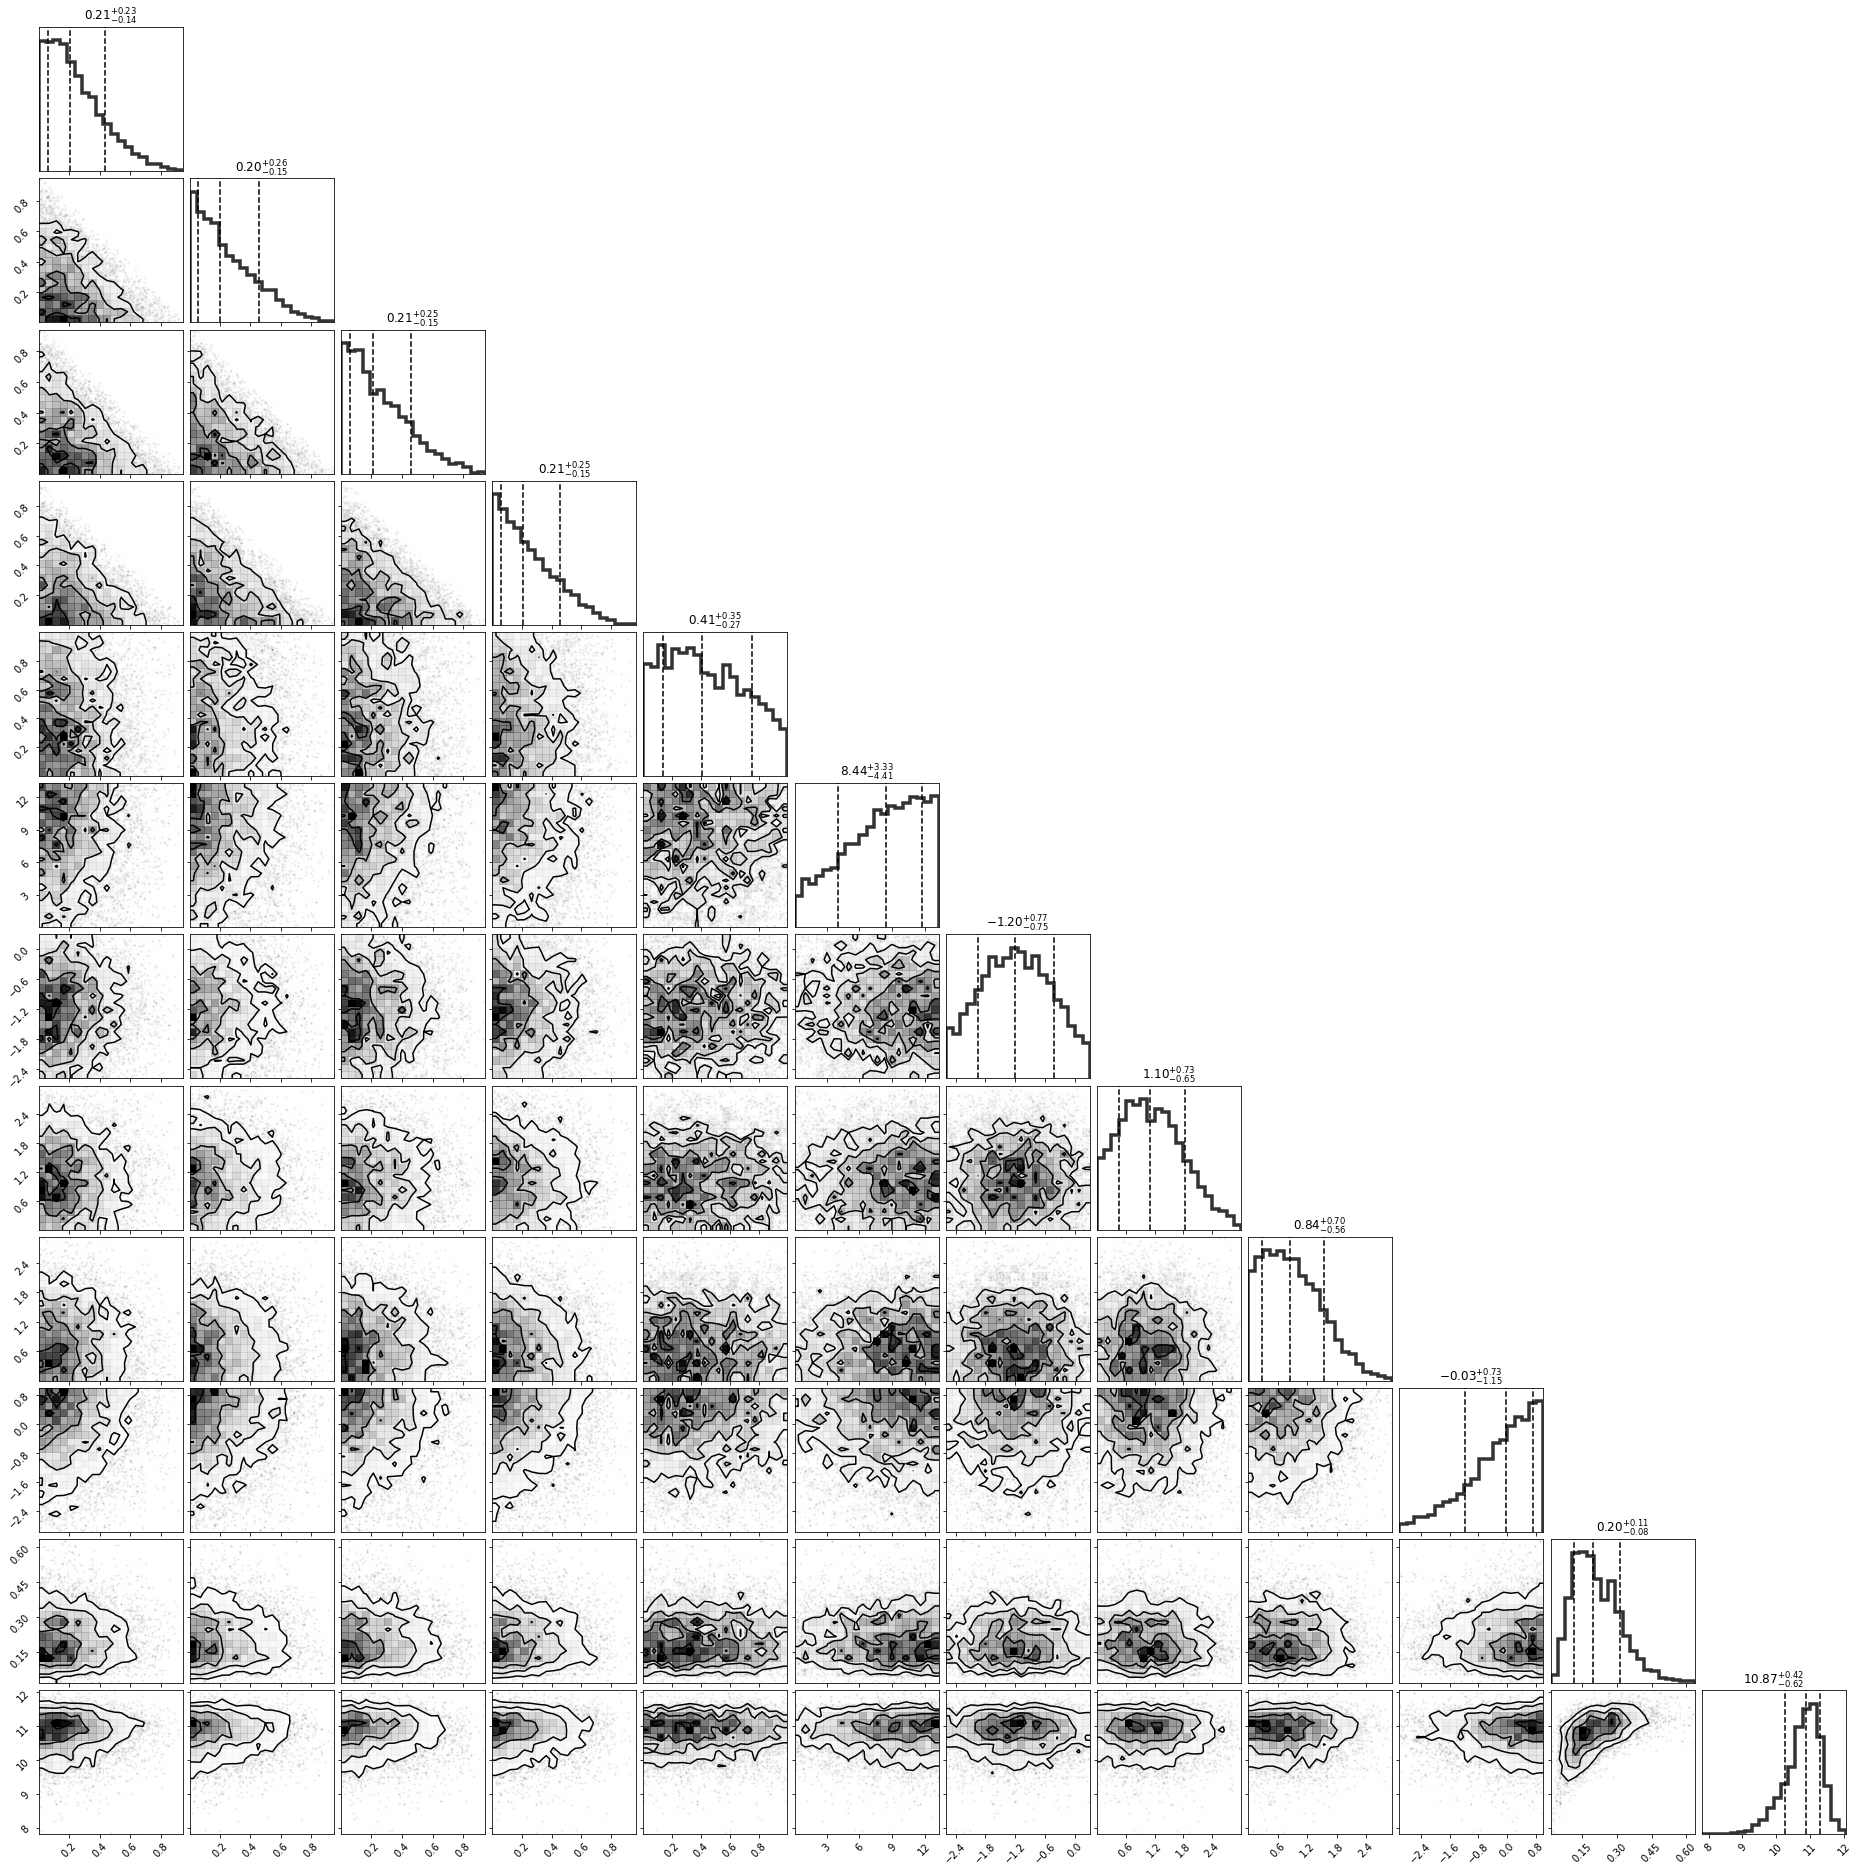

In [33]:
figure = corner.corner(params[np.random.randint(0, len(params), 5000)], #params, 
                       quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.3,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

In [35]:
name = 'NMF'
wave = np.load(f'./train_sed_{name}/{name.lower()}_seds/fsps.wavelength.npy')

if name == 'NMF_ZH':
    spec_dir = [
        f'./train_sed_{name}/best_emu/speculator_best_recon_model_{name}_{i_bin}.pkl' for i_bin in range(0, 5)]
    params_name = ['kappa1_sfh', 'kappa2_sfh', 'kappa3_sfh',
                   'fburst', 'tburst', 'gamma1_zh', 'gamma2_zh',
                   'dust1', 'dust2',
                   'dust_index', 'redshift', 'logm']
else:
    spec_dir = [
        f'./train_sed_{name}/best_emu/speculator_best_recon_model_{name}.emu_{i_bin}.pkl' for i_bin in range(0, 5)]
    params_name = ['kappa1_sfh', 'kappa2_sfh', 'kappa3_sfh',
                   'fburst', 'tburst', 'logzsol',
                   'dust1', 'dust2',
                   'dust_index', 'redshift', 'logm']
speculator = SuperSpeculator(
    speculators_dir=spec_dir,
    str_wbin=['.w1000_2000',
              '.w2000_3600',
              '.w3600_5500',
              '.w5500_7410',
              '.w7410_60000'],
    wavelength=wave,
    params_name=params_name,
    device='cuda', use_speclite=True)
gama_filters = ['sdss2010-{0}'.format(b) for b in 'ugriz']
speculator._calc_transmission(gama_filters)

noise = None #'gama'
noise_model_dir = './noise_model/gama_noise_model_mag_dr3_apmatch.npy'

In [36]:
test_par = torch.Tensor(params_unt).to('cuda')
mags = speculator._predict_mag_with_mass_redshift(test_par, noise=None, #SNR=5,
                                           noise_model_dir=noise_model_dir).detach().cpu().numpy()
np.save('./NDE/GAMA/NMF/mock_params.npy', params_unt)
np.save('./NDE/GAMA/NMF/mock_mags_no_noise.npy', mags)
del mags
torch.cuda.empty_cache()
gc.collect()

mags = speculator._predict_mag_with_mass_redshift(test_par, noise='gama', SNR=1,
                                           noise_model_dir=noise_model_dir).detach().cpu().numpy()
np.save('./NDE/GAMA/NMF/mock_mags_gama_apmatch_noise.npy', mags)
del mags
torch.cuda.empty_cache()
gc.collect()

mags = speculator._predict_mag_with_mass_redshift(test_par, noise='snr', SNR=5,
                                           noise_model_dir=noise_model_dir).detach().cpu().numpy()
np.save('./NDE/GAMA/NMF/mock_mags_snr_5.npy', mags)
del mags
torch.cuda.empty_cache()
gc.collect()

0

#### Load GAMA photometry catalog

In [37]:
from astropy.table import Table
from popsed.utils import flux2mag, sigma_flux2mag

In [38]:
name = 'NMF'
wave = np.load(f'./train_sed_{name}/{name.lower()}_seds/fsps.wavelength.npy')

if name == 'NMF_ZH':
    spec_dir = [
        f'./train_sed_{name}/best_emu/speculator_best_recon_model_{name}_{i_bin}.pkl' for i_bin in range(0, 5)]
    params_name = ['kappa1_sfh', 'kappa2_sfh', 'kappa3_sfh',
                   'fburst', 'tburst', 'gamma1_zh', 'gamma2_zh',
                   'dust1', 'dust2',
                   'dust_index', 'redshift', 'logm']
else:
    spec_dir = [
        f'./train_sed_{name}/best_emu/speculator_best_recon_model_{name}.emu_{i_bin}.pkl' for i_bin in range(0, 5)]
    params_name = ['kappa1_sfh', 'kappa2_sfh', 'kappa3_sfh',
                   'fburst', 'tburst', 'logzsol',
                   'dust1', 'dust2',
                   'dust_index', 'redshift', 'logm']
speculator = SuperSpeculator(
    speculators_dir=spec_dir,
    str_wbin=['.w1000_2000',
              '.w2000_3600',
              '.w3600_5500',
              '.w5500_7410',
              '.w7410_60000'],
    wavelength=wave,
    params_name=params_name,
    device='cuda', use_speclite=True)
gama_filters = ['sdss2010-{0}'.format(b) for b in 'ugriz']
speculator._calc_transmission(gama_filters)

noise = 'gama'
noise_model_dir = './noise_model/gama_noise_model_mag_dr3_apmatch.npy'

In [51]:
X_data = np.load('./NDE/GAMA/NMF/mock_mags_gama_apmatch_noise.npy')[:, :]
print('Total number of samples:', len(X_data))

Total number of samples: 70000


In [40]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [41]:
# Determine the intrinsic sampling loss
X_datas = []
for i in range(5):
    ind = np.random.randint(0, len(X_data), 10000)
    X_datas.append(torch.Tensor(X_data[ind]).to('cuda'))
from torch.utils.data import DataLoader
from geomloss import SamplesLoss
L = SamplesLoss(loss='sinkhorn', **{'p': 1, 'blur': 0.002, 'scaling': 0.9})
intr_loss = []
for i in range(5):
    dataloader = DataLoader(X_data, batch_size=10000, shuffle=True)
    data_loss = 0.
    for x in dataloader:
        data_loss += L(X_datas[i], x.to('cuda'))
    loss = data_loss / len(dataloader)
    intr_loss.append(loss.item())

print("Intrinsic sampling loss:", np.mean(intr_loss), '+-', np.std(intr_loss))
del X_datas
gc.collect()
torch.cuda.empty_cache()

Intrinsic sampling loss: 0.2616092264652252 +- 0.0012230035317344198


In [47]:
scaler = StandardScaler(device='cpu')
scaler.fit(X_data)
_X_data = scaler.transform(X_data)
# Determine the intrinsic sampling loss
X_datas = []
for i in range(5):
    ind = np.random.randint(0, len(_X_data), 10000)
    X_datas.append(torch.Tensor(_X_data[ind]).to('cuda'))
from torch.utils.data import DataLoader
from geomloss import SamplesLoss
L = SamplesLoss(loss='sinkhorn', **{'p': 1, 'blur': 0.002, 'scaling': 0.9})
intr_loss = []
for i in range(5):
    dataloader = DataLoader(_X_data, batch_size=10000, shuffle=True)
    data_loss = 0.
    for x in dataloader:
        data_loss += L(X_datas[i], x.to('cuda'))
    loss = data_loss / len(dataloader)
    intr_loss.append(loss.item())

print("Intrinsic sampling loss:", np.mean(intr_loss), '+-', np.std(intr_loss))
del X_datas
gc.collect()
torch.cuda.empty_cache()

Intrinsic sampling loss: 0.14481559097766877 +- 0.0007281961161441255


In [52]:
from popsed.nde import transform_nmf_params, inverse_transform_nmf_params

In [53]:
_prior_NDE = speculator.bounds.copy()
_prior_NDE[-2] = np.array([0., 0.8])
_prior_NDE[-1] = np.array([7.5, 13.])

kappa1_sfh, kappa2_sfh, kappa3_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index, redshif, logmstar, 

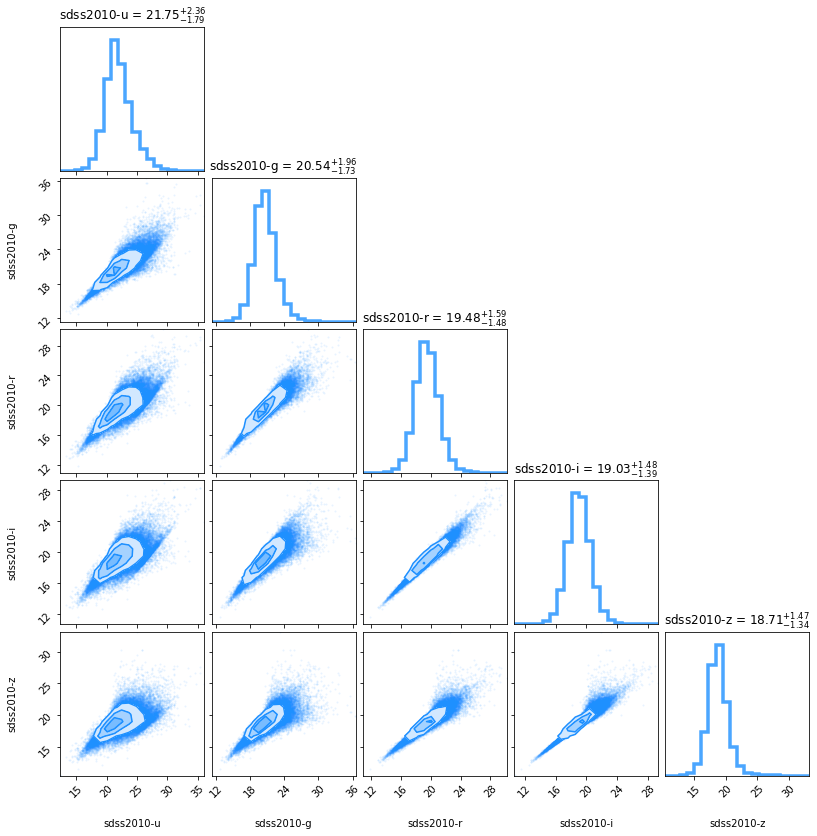

In [54]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Noise-less photometry')
b_line = mlines.Line2D([], [], color='dodgerblue', label=r'Noisy photometry')

labels = gama_filters

figure = corner.corner(X_data,
                       color='dodgerblue', labels=labels,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.1, fill_contours=True,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12},
                       hist_kwargs={'density': True})

p = 1
blur = 0.1, loss=0.07
blur = 0.01, loss=0.196
blur = 0.002, loss=0.204

p = 2
blur = 0.1, loss=0.012
blur = 0.01, loss=0.02
blur = 0.002, loss=0.0184

kappa1_sfh, kappa2_sfh, kappa3_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index, redshift, logmstar

### now we provide the redshift distribution to it

In [55]:
from popsed.speculator import StandardScaler
from popsed.nde import WassersteinNeuralDensityEstimator
from geomloss import SamplesLoss

In [56]:
seed = 0
np.random.seed(seed)

_bounds = np.zeros_like(speculator.bounds)
_bounds = np.zeros_like(_bounds)
_bounds = np.vstack([-np.abs(np.random.normal(size=len(_bounds)) / 10),
                    np.abs(np.random.normal(size=len(_bounds)) / 10)]).T
_stds = np.ones(len(_bounds))

X_train, X_vali = train_test_split(X_data, test_size=0.15)
if name == 'NMF_ZH':
    Y_train = torch.ones(len(X_train), 12)
else:
    Y_train = torch.ones(len(X_train), 11)
            
        
NDE_theta = WassersteinNeuralDensityEstimator(method='nsf',
                                              name=name,
                                              num_transforms=20,
                                              num_bins=50,
                                              hidden_features=100,
                                              seed=seed,
                                              output_dir=None,
                                              initial_pos={'bounds': _bounds,
                                                           'std': _stds,
                                                           },
                                              normalize=False,
                                              regularize=True,
                                              NDE_prior=_prior_NDE)
NDE_theta.build(
    Y_train,
    X_train,
    filterset=gama_filters,
    z_score=False,
    optimizer='adam')
NDE_theta.load_validation_data(X_vali)
NDE_theta.bounds = speculator.bounds
NDE_theta.params_name = speculator.params_name
NDE_theta.external_redshift_data = None  # z_nsa

print('Total number of params in the model:',
      sum(p.numel() for p in NDE_theta.net.parameters() if p.requires_grad))

[ 0.00022083  0.04303171 -0.03154493 -0.07780146 -0.09349954  0.0618957
 -0.04445672  0.02628044  0.08193096  0.07257643  0.04874855]
Total number of params in the model: 2479030


In [57]:
# del X_data
gc.collect()
torch.cuda.empty_cache()

min_loss = 0.20619666576385498

In [58]:
noise = 'gama'
max_epochs = 30
anneal_tau = 10
anneal_coeff = 20
max_lr = 3e-4
NDE_theta.output_dir = "./NDE/GAMA/anneal/mock/test/"

blurs = [0.3, 0.3, 0.2, 0.1, 0.1,
         0.1, 0.05, 0.05, 0.05] + [0.002] * max_epochs
snrs = [1 + anneal_coeff * np.exp(- anneal_tau / max_epochs * i)
        for i in range(max_epochs)]  # larger anneal_coeff, after annealing
steps = 30

try:
    print('### Training NDE for seed {0}'.format(seed))
    scheduler = torch.optim.lr_scheduler.OneCycleLR(NDE_theta.optimizer,
                                                    max_lr=max_lr,
                                                    steps_per_epoch=steps,
                                                    epochs=max_epochs,
                                                    anneal_strategy='cos',
                                                    div_factor=10, final_div_factor=100)
    for i, epoch in enumerate(range(max_epochs)):
        np.save(os.path.join(NDE_theta.output_dir, f'{NDE_theta.method}_{NDE_theta.seed}_sample_{i+1}.npy'),
                NDE_theta.sample(5000).detach().cpu().numpy())

        print('    Epoch {0}'.format(epoch))
        print('\n\n')
        print('    lr:', NDE_theta.optimizer.param_groups[0]['lr'])
        NDE_theta.train(n_epochs=steps,
                        speculator=speculator,
                        add_penalty=False,
                        n_samples=10000,
                        noise=noise,
                        noise_model_dir=noise_model_dir,
                        SNR=snrs[i],
                        sinkhorn_kwargs={
                            'p': 1, 'blur': blurs[i], 'scaling': 0.9},
                        scheduler=scheduler
                        )

    print(f'    Succeeded in training for {max_epochs} epochs!')
    print('    Saving NDE model for seed {0}'.format(seed))
    print('\n\n')
    np.save(os.path.join(NDE_theta.output_dir, f'{NDE_theta.method}_{NDE_theta.seed}_sample_{i+1}.npy'),
            NDE_theta.sample(5000).detach().cpu().numpy())
    NDE_theta.save_model(
        os.path.join(NDE_theta.output_dir,
                     f'nde_theta_last_model_{NDE_theta.method}_{NDE_theta.seed}.pkl')
    )
except Exception as e:
    print(e)

### Training NDE for seed 0
    Epoch 0



    lr: 3.0000000000000024e-05


Loss = 6.611 (train), 6.390 (vali), 6.821 (bad ratio): 100%|███████████████████████| 30/30 [01:18<00:00,  2.61s/epochs]


    Epoch 1



    lr: 3.820151867012196e-05


Loss = 3.175 (train), 2.996 (vali), 5.393 (bad ratio): 100%|███████████████████████| 30/30 [01:17<00:00,  2.59s/epochs]


    Epoch 2



    lr: 6.180955751757875e-05


Loss = 0.971 (train), 1.007 (vali), 4.420 (bad ratio): 100%|███████████████████████| 30/30 [01:18<00:00,  2.63s/epochs]


    Epoch 3



    lr: 9.795564585537213e-05


Loss = 0.316 (train), 0.428 (vali), 4.914 (bad ratio): 100%|███████████████████████| 30/30 [01:22<00:00,  2.74s/epochs]


    Epoch 4



    lr: 0.0001422478900782534


Loss = 0.237 (train), 0.343 (vali), 4.744 (bad ratio): 100%|███████████████████████| 30/30 [01:21<00:00,  2.71s/epochs]


    Epoch 5



    lr: 0.00018930460621680684


Loss = 0.216 (train), 0.306 (vali), 4.631 (bad ratio): 100%|███████████████████████| 30/30 [01:20<00:00,  2.70s/epochs]


    Epoch 6



    lr: 0.00023340821596044028


Loss = 0.275 (train), 0.371 (vali), 4.688 (bad ratio): 100%|███████████████████████| 30/30 [01:26<00:00,  2.87s/epochs]


    Epoch 7



    lr: 0.000269199955179788


Loss = 0.264 (train), 0.381 (vali), 4.580 (bad ratio): 100%|███████████████████████| 30/30 [01:25<00:00,  2.86s/epochs]


    Epoch 8



    lr: 0.00029233098509790753


Loss = 0.253 (train), 0.367 (vali), 4.490 (bad ratio): 100%|███████████████████████| 30/30 [01:26<00:00,  2.87s/epochs]


    Epoch 9



    lr: 0.00029999813686425446


Loss = 0.318 (train), 0.428 (vali), 4.491 (bad ratio): 100%|███████████████████████| 30/30 [01:50<00:00,  3.68s/epochs]


    Epoch 10



    lr: 0.0002982130855743032


Loss = 0.305 (train), 0.426 (vali), 4.635 (bad ratio): 100%|███████████████████████| 30/30 [01:50<00:00,  3.68s/epochs]


    Epoch 11



    lr: 0.00029312054961950584


Loss = 0.304 (train), 0.410 (vali), 4.527 (bad ratio): 100%|███████████████████████| 30/30 [01:50<00:00,  3.68s/epochs]


    Epoch 12



    lr: 0.00028483428783793017


Loss = 0.299 (train), 0.421 (vali), 4.625 (bad ratio): 100%|███████████████████████| 30/30 [01:50<00:00,  3.67s/epochs]


    Epoch 13



    lr: 0.0002735394016251412


Loss = 0.310 (train), 0.429 (vali), 4.806 (bad ratio): 100%|███████████████████████| 30/30 [01:49<00:00,  3.67s/epochs]


    Epoch 14



    lr: 0.00025948820007489496


Loss = 0.295 (train), 0.426 (vali), 4.441 (bad ratio): 100%|███████████████████████| 30/30 [01:50<00:00,  3.67s/epochs]


    Epoch 15



    lr: 0.0002429945638109125


Loss = 0.292 (train), 0.411 (vali), 4.476 (bad ratio): 100%|███████████████████████| 30/30 [01:50<00:00,  3.67s/epochs]


    Epoch 16



    lr: 0.00022442693341241752


Loss = 0.294 (train), 0.432 (vali), 4.728 (bad ratio): 100%|███████████████████████| 30/30 [01:49<00:00,  3.67s/epochs]


    Epoch 17



    lr: 0.00020420007906042688


Loss = 0.292 (train), 0.438 (vali), 4.585 (bad ratio): 100%|███████████████████████| 30/30 [01:49<00:00,  3.66s/epochs]


    Epoch 18



    lr: 0.0001827658352572933


Loss = 0.290 (train), 0.415 (vali), 4.594 (bad ratio): 100%|███████████████████████| 30/30 [01:50<00:00,  3.67s/epochs]


    Epoch 19



    lr: 0.00016060300759055714


Loss = 0.298 (train), 0.425 (vali), 4.514 (bad ratio): 100%|███████████████████████| 30/30 [01:49<00:00,  3.67s/epochs]


    Epoch 20



    lr: 0.00013820667700732307


Loss = 0.293 (train), 0.409 (vali), 4.556 (bad ratio): 100%|███████████████████████| 30/30 [01:50<00:00,  3.67s/epochs]


    Epoch 21



    lr: 0.00011607714052399822


Loss = 0.293 (train), 0.407 (vali), 4.493 (bad ratio): 100%|███████████████████████| 30/30 [01:49<00:00,  3.67s/epochs]


    Epoch 22



    lr: 9.470873541766184e-05


Loss = 0.291 (train), 0.422 (vali), 4.496 (bad ratio): 100%|███████████████████████| 30/30 [01:49<00:00,  3.66s/epochs]


    Epoch 23



    lr: 7.4578796548163e-05


Loss = 0.296 (train), 0.416 (vali), 4.518 (bad ratio): 100%|███████████████████████| 30/30 [01:49<00:00,  3.66s/epochs]


    Epoch 24



    lr: 5.6136993486123615e-05


Loss = 0.291 (train), 0.426 (vali), 4.488 (bad ratio): 100%|███████████████████████| 30/30 [02:09<00:00,  4.32s/epochs]


    Epoch 25



    lr: 3.979528563778748e-05


Loss = 0.293 (train), 0.420 (vali), 4.538 (bad ratio): 100%|███████████████████████| 30/30 [02:14<00:00,  4.49s/epochs]


    Epoch 26



    lr: 2.591871975262701e-05


Loss = 0.291 (train), 0.418 (vali), 4.611 (bad ratio): 100%|███████████████████████| 30/30 [02:19<00:00,  4.67s/epochs]


    Epoch 27



    lr: 1.4817275382181892e-05


Loss = 0.291 (train), 0.410 (vali), 4.514 (bad ratio): 100%|███████████████████████| 30/30 [01:49<00:00,  3.65s/epochs]


    Epoch 28



    lr: 6.7389404491032165e-06


Loss = 0.295 (train), 0.412 (vali), 4.548 (bad ratio): 100%|███████████████████████| 30/30 [01:49<00:00,  3.65s/epochs]


    Epoch 29



    lr: 1.8641716067493658e-06


Loss = 0.291 (train), 0.429 (vali), 4.549 (bad ratio): 100%|███████████████████████| 30/30 [01:49<00:00,  3.65s/epochs]


    Succeeded in training for 30 epochs!
    Saving NDE model for seed 0





In [ ]:
noise = 'gama'
max_epochs = 30
steps = 30
blurs = [0.3, 0.2, 0.1, 0.1, 0.1, 0.05, 0.05, 0.05] + [0.002] * 30

scheduler = torch.optim.lr_scheduler.OneCycleLR(NDE_theta.optimizer,
                                                max_lr=3e-4, #3e-4, #4e-4, #2e-4, #3e-4, #8e-4, #5e-4,
                                                steps_per_epoch=steps,
                                                epochs=max_epochs,
                                                anneal_strategy='cos',
                                                div_factor=10, final_div_factor=100)

for i, epoch in enumerate(range(max_epochs)):
    print('    Epoch {0}'.format(epoch))
    print('    lr:', NDE_theta.optimizer.param_groups[0]['lr'])
    print('    blur:', blurs[i])
    np.save(f'./NDE/GAMA/NMF/sample_anneal_3e-4/sample_anneal_{i}.npy', NDE_theta.sample(5000).detach().cpu().numpy())
    NDE_theta.train(n_epochs=steps,
                    speculator=speculator,
                    add_penalty=False,
                    n_samples=10000,
                    noise=noise, noise_model_dir=noise_model_dir, SNR=1 + 17 * 0.8**(0.9 * i),
                    sinkhorn_kwargs={
                        'p': 1, 'blur': blurs[i], 'scaling': 0.9},
                    scheduler=scheduler, detect_anomaly=False,
                    )
np.save(f'./NDE/GAMA/NMF/sample_anneal_3e-4/sample_anneal_{i+1}.npy', NDE_theta.sample(5000).detach().cpu().numpy())

(0.17674949937296788, 0.6)

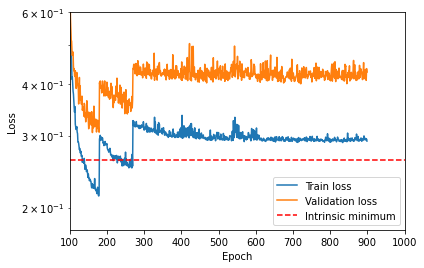

In [60]:
NDE_theta.plot_loss(0.261)
plt.yscale('log')

plt.xlim(100, 1000)
plt.ylim(0, 0.6)

In [61]:
samples = NDE_theta.sample(5000)
_samples_unt = inverse_transform_nmf_params(samples, NDE_theta.NDE_prior).detach().cpu().numpy()
_samples = np.hstack([prior.FlatDirichletPrior(4).transform(_samples_unt[:, :3]),
                      _samples_unt[:, 3:-1], 
                      _samples_unt[:, -1:]])

0 5000
>40 0


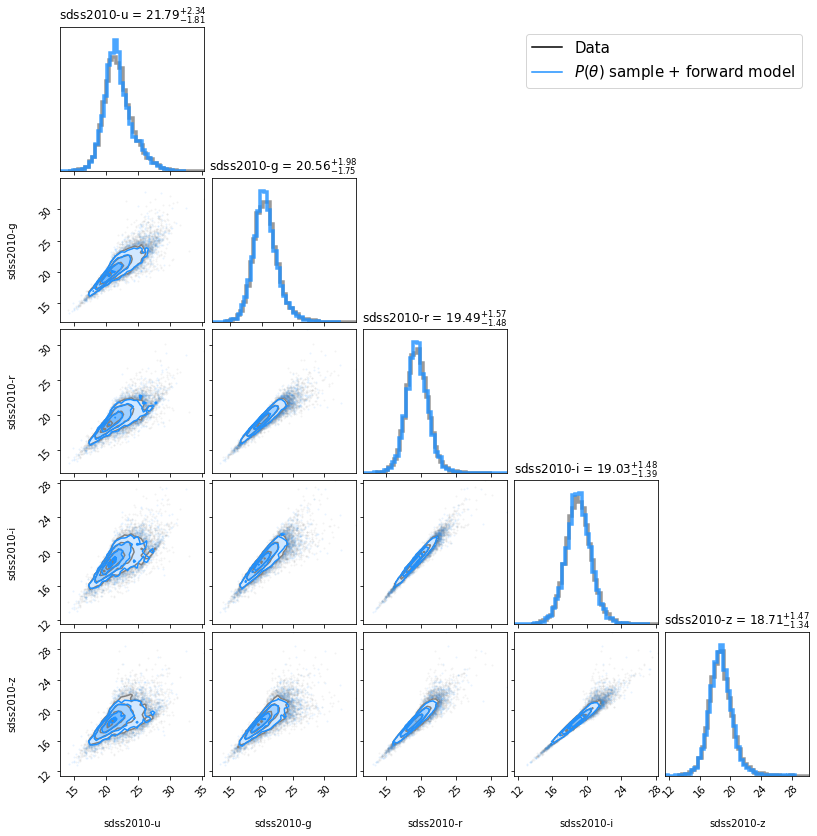

In [62]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Data')
#r_line = mlines.Line2D([], [], color='tomato', label='NDE for the data')
b_line = mlines.Line2D([], [], color='dodgerblue', label=r'$P(\theta)$ sample + forward model')

labels = gama_filters

figure = corner.corner(X_vali,#.cpu().detach().numpy(), 
                       color='gray', labels=labels, bins=40,
                       smooth=0.2, fill_contours=True,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

mags = speculator._predict_mag_with_mass_redshift(
#     inverse_transform_nmf_params_given_z(samples, NDE_theta.NDE_prior, NDE_theta.cdf_z), 
    inverse_transform_nmf_params(samples, NDE_theta.NDE_prior),
                                                  filterset=gama_filters,
                                                  noise=noise,
                                                  noise_model_dir=noise_model_dir, SNR=1,
                                                  ).cpu().detach().numpy()
print(np.isnan(mags).any(axis=1).sum(), len(mags))
print('>40', np.any(mags > 40, axis=1).sum())
mags = mags[~(np.isinf(mags).any(axis=1)| np.isnan(mags).any(axis=1))]
mags = mags[~np.any(mags > 40, axis=1)]
nf_plot = corner.corner(mags, 
                  fig=figure, labels=labels, bins=40,
                        #range=[[14, 25]] * 5,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.2, fill_contours=True,
                  show_titles=False, 
                        title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

ax = nf_plot.get_axes()[4]
ax.legend(handles=[k_line, b_line], fontsize=15)#, bbox_to_anchor=(0., 1.0, 1., .0))

In [63]:
true_params_unt = np.load('./NDE/GAMA/NMF/mock_params.npy')
true_params_unt = true_params_unt[np.random.randint(0, len(true_params_unt), 5000)]
true_params = np.hstack([prior.FlatDirichletPrior(4).transform(true_params_unt[:, :3]),
                      true_params_unt[:, 3:-1], 
                      true_params_unt[:, -1:]])

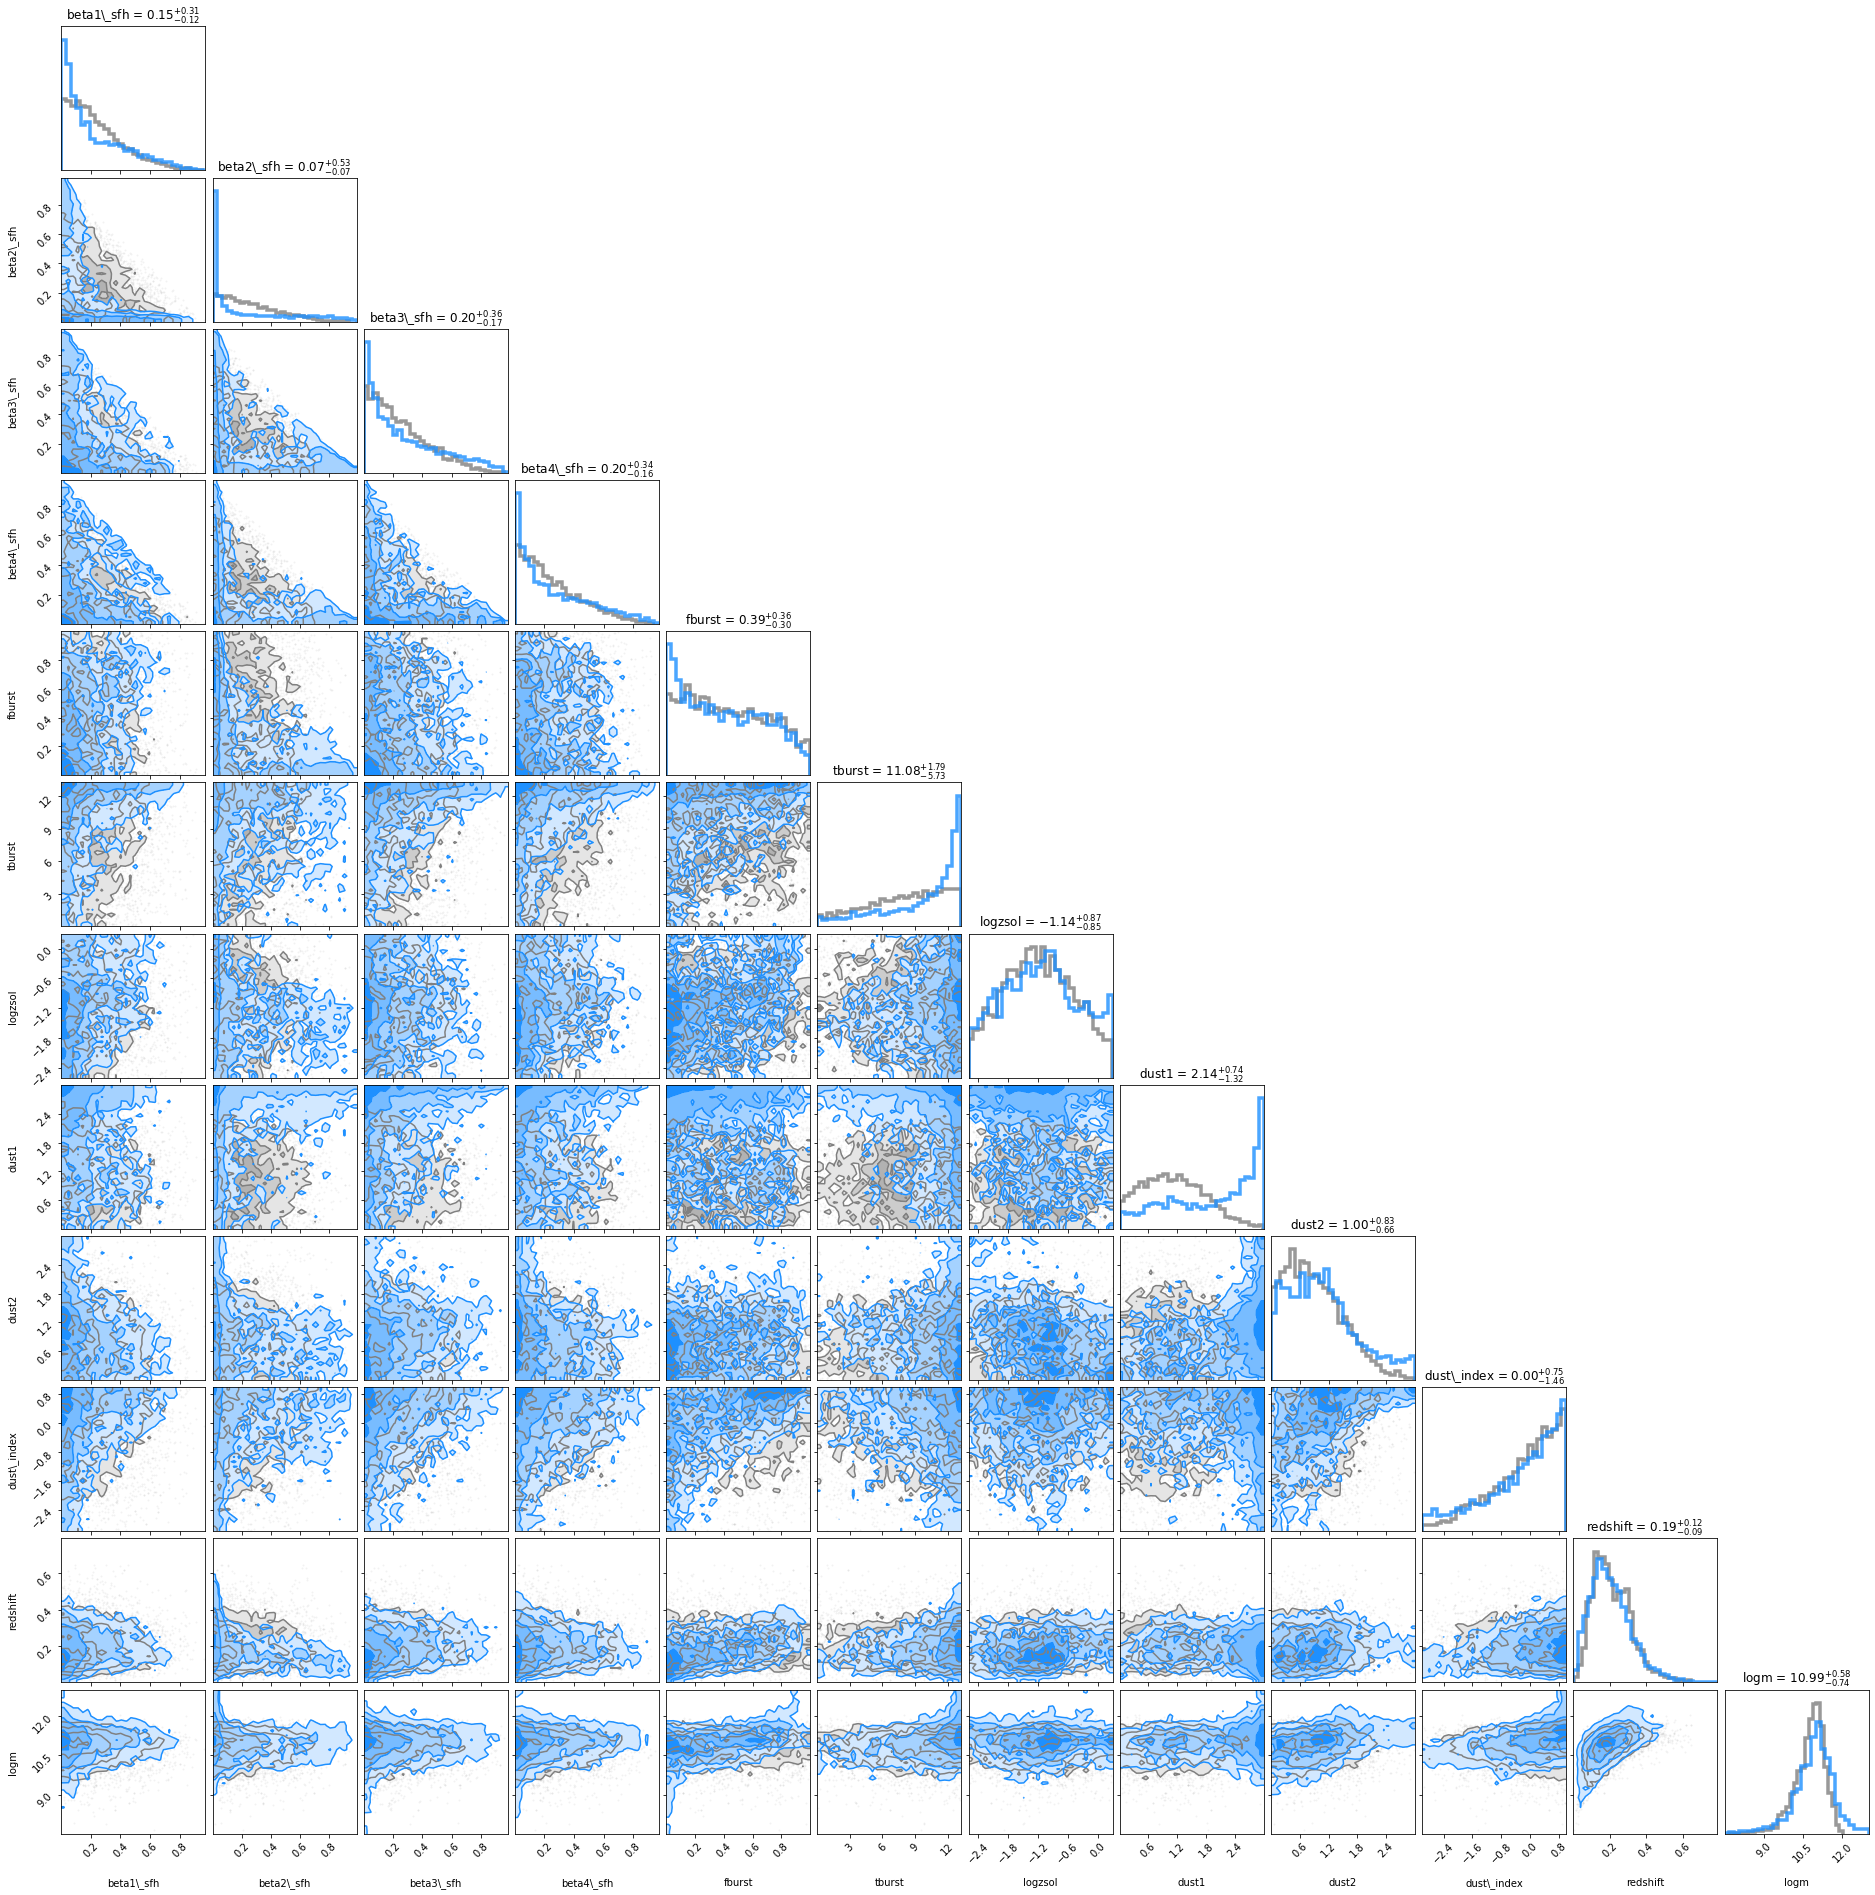

In [66]:
_labels = [f'beta{i}_sfh' for i in range(1,5)] + speculator.params_name[3:]
_labels = [key.replace('_', '\_') for key in _labels]

figure = corner.corner(true_params, 
                  labels=_labels, bins=30,
                  color='gray', # quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.5, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)


nf_plot = corner.corner(_samples, 
                        fig=figure,
                  labels=_labels, bins=30,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.5, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True}, plot_datapoints=False)

# ax = nf_plot.get_axes()[1]
# ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

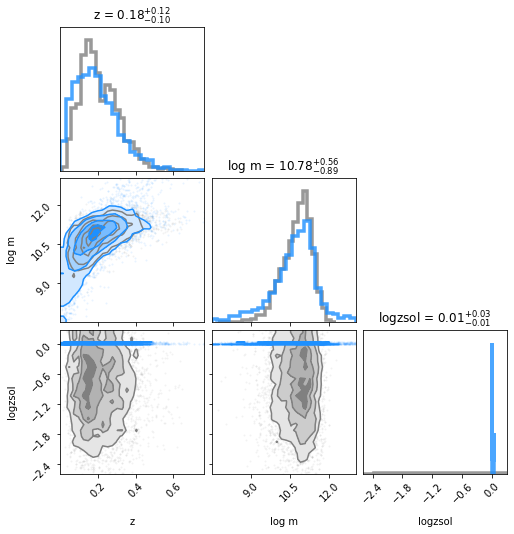

In [25]:
z_mass_met = np.hstack([true_params[:, -2:], true_params[:, 6:7]])
figure = corner.corner(z_mass_met, 
                  labels=['z', 'log m', 'logzsol'], bins=25,
                  color='gray', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.5, fill_contours=True,
#                        range=[[0, 1], [8, 13], [-2, 1]], 
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

figure = corner.corner(np.hstack([_samples[:, -2:-1], _samples[:, -1:], _samples[:, 6:7]]), 
                       fig=figure,
                  labels=['z', 'log m', 'logzsol'], bins=25,
                  color='dodgerblue', # quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.5, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

# ax = nf_plot.get_axes()[1]
# ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

In [46]:
np.sort(true_params[:, -2])

array([0.00657144, 0.0066278 , 0.00664884, ..., 0.97983915, 0.98794556,
       0.9928388 ])

(array([193., 466., 620., 746., 738., 645., 528., 369., 229., 154., 125.,
         67.,  36.,  32.,  12.,  10.,   8.,   5.,   3.,   1.,   6.,   2.,
          0.,   1.,   4.]),
 array([0.00657144, 0.04602214, 0.08547283, 0.12492352, 0.16437422,
        0.20382491, 0.24327561, 0.2827263 , 0.322177  , 0.36162769,
        0.40107839, 0.44052908, 0.47997977, 0.51943047, 0.55888116,
        0.59833186, 0.63778255, 0.67723325, 0.71668394, 0.75613463,
        0.79558533, 0.83503602, 0.87448672, 0.91393741, 0.95338811,
        0.9928388 ]),
 <BarContainer object of 25 artists>)

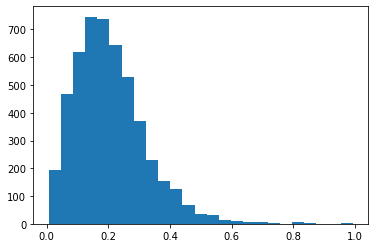

In [66]:
plt.hist(true_params[:, -2], bins=25)
# plt.xlim(0, 0.15)

In [64]:
from popsed.models import NMF_ZH
model = NMF_ZH(burst=True, peraa=True)

Initialize NMF-based SPS model
Input parameters : logmstar, beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh, fburst, tburst, gamma1_zh, gamma2_zh, dust1, dust2, dust_index


In [63]:
params = np.hstack([_samples[:, -1:], _samples[:, :-1]])

In [69]:
sfr = np.zeros(len(params))
age = np.zeros(len(params))
zmw = np.zeros(len(params))

for i in range(len(params)):
    tt = params[i]
    sfr[i] = model.avgSFR(tt[:-1], zred=tt[-1], dt=1)
    age[i] = model.tage_MW(tt[:-1], zred=tt[-1])
    zmw[i] = model.Z_MW(tt[:-1], zred=tt[-1])

In [78]:
redshift = params[:, -1]
logmstar = params[:, 0]
logzsol = np.log10(zmw / 0.019)

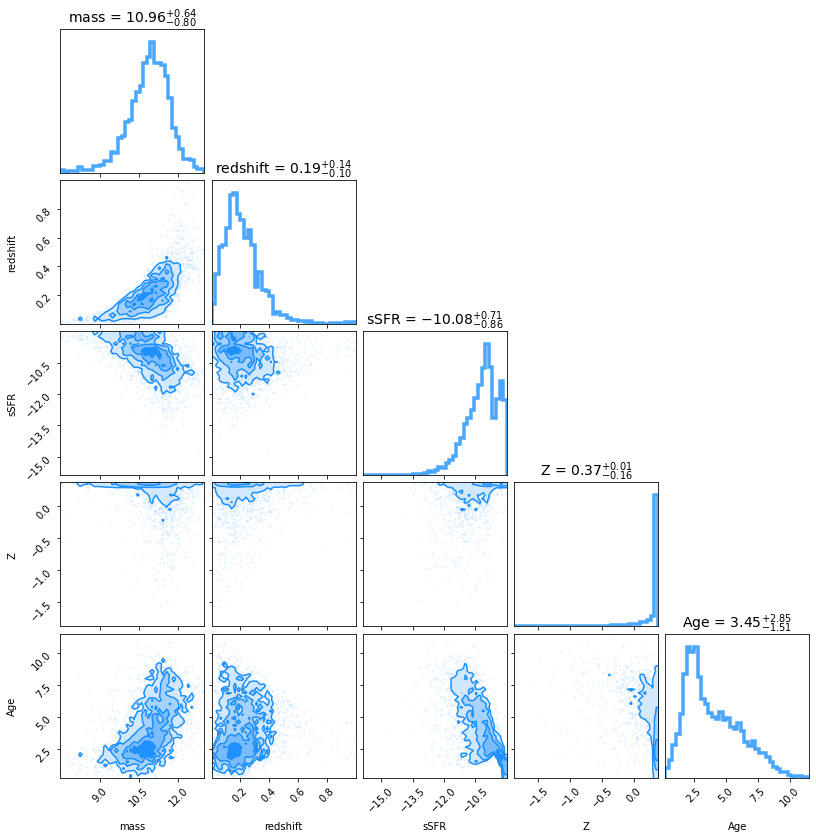

In [79]:
figure = corner.corner(np.vstack([logmstar, redshift, np.log10(sfr)-logmstar, logzsol, age]).T, 
                  labels=['mass','redshift', 'sSFR', 'Z', 'Age'], bins=40,
                  color='dodgerblue', # quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.3, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 14}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

# ax = figure.get_axes()[2]
# ax.legend(handles=[k_line, b_line], fontsize=17, bbox_to_anchor=(0., 1.0, 1.3, .0))

# plt.suptitle('GAMA DR3 aperture-matched photometry, SDSS $ugriz$', y=1.06)

In [35]:
a, b = np.histogram(z_mass_truth[:, 0].ravel(), bins=35, range=(0, 0.5))
b[np.argmax(a)]

0.15714286

In [59]:
_samples_unt = inverse_transform_nmf_params(samples, NDE_theta.NDE_prior).detach().cpu().numpy()

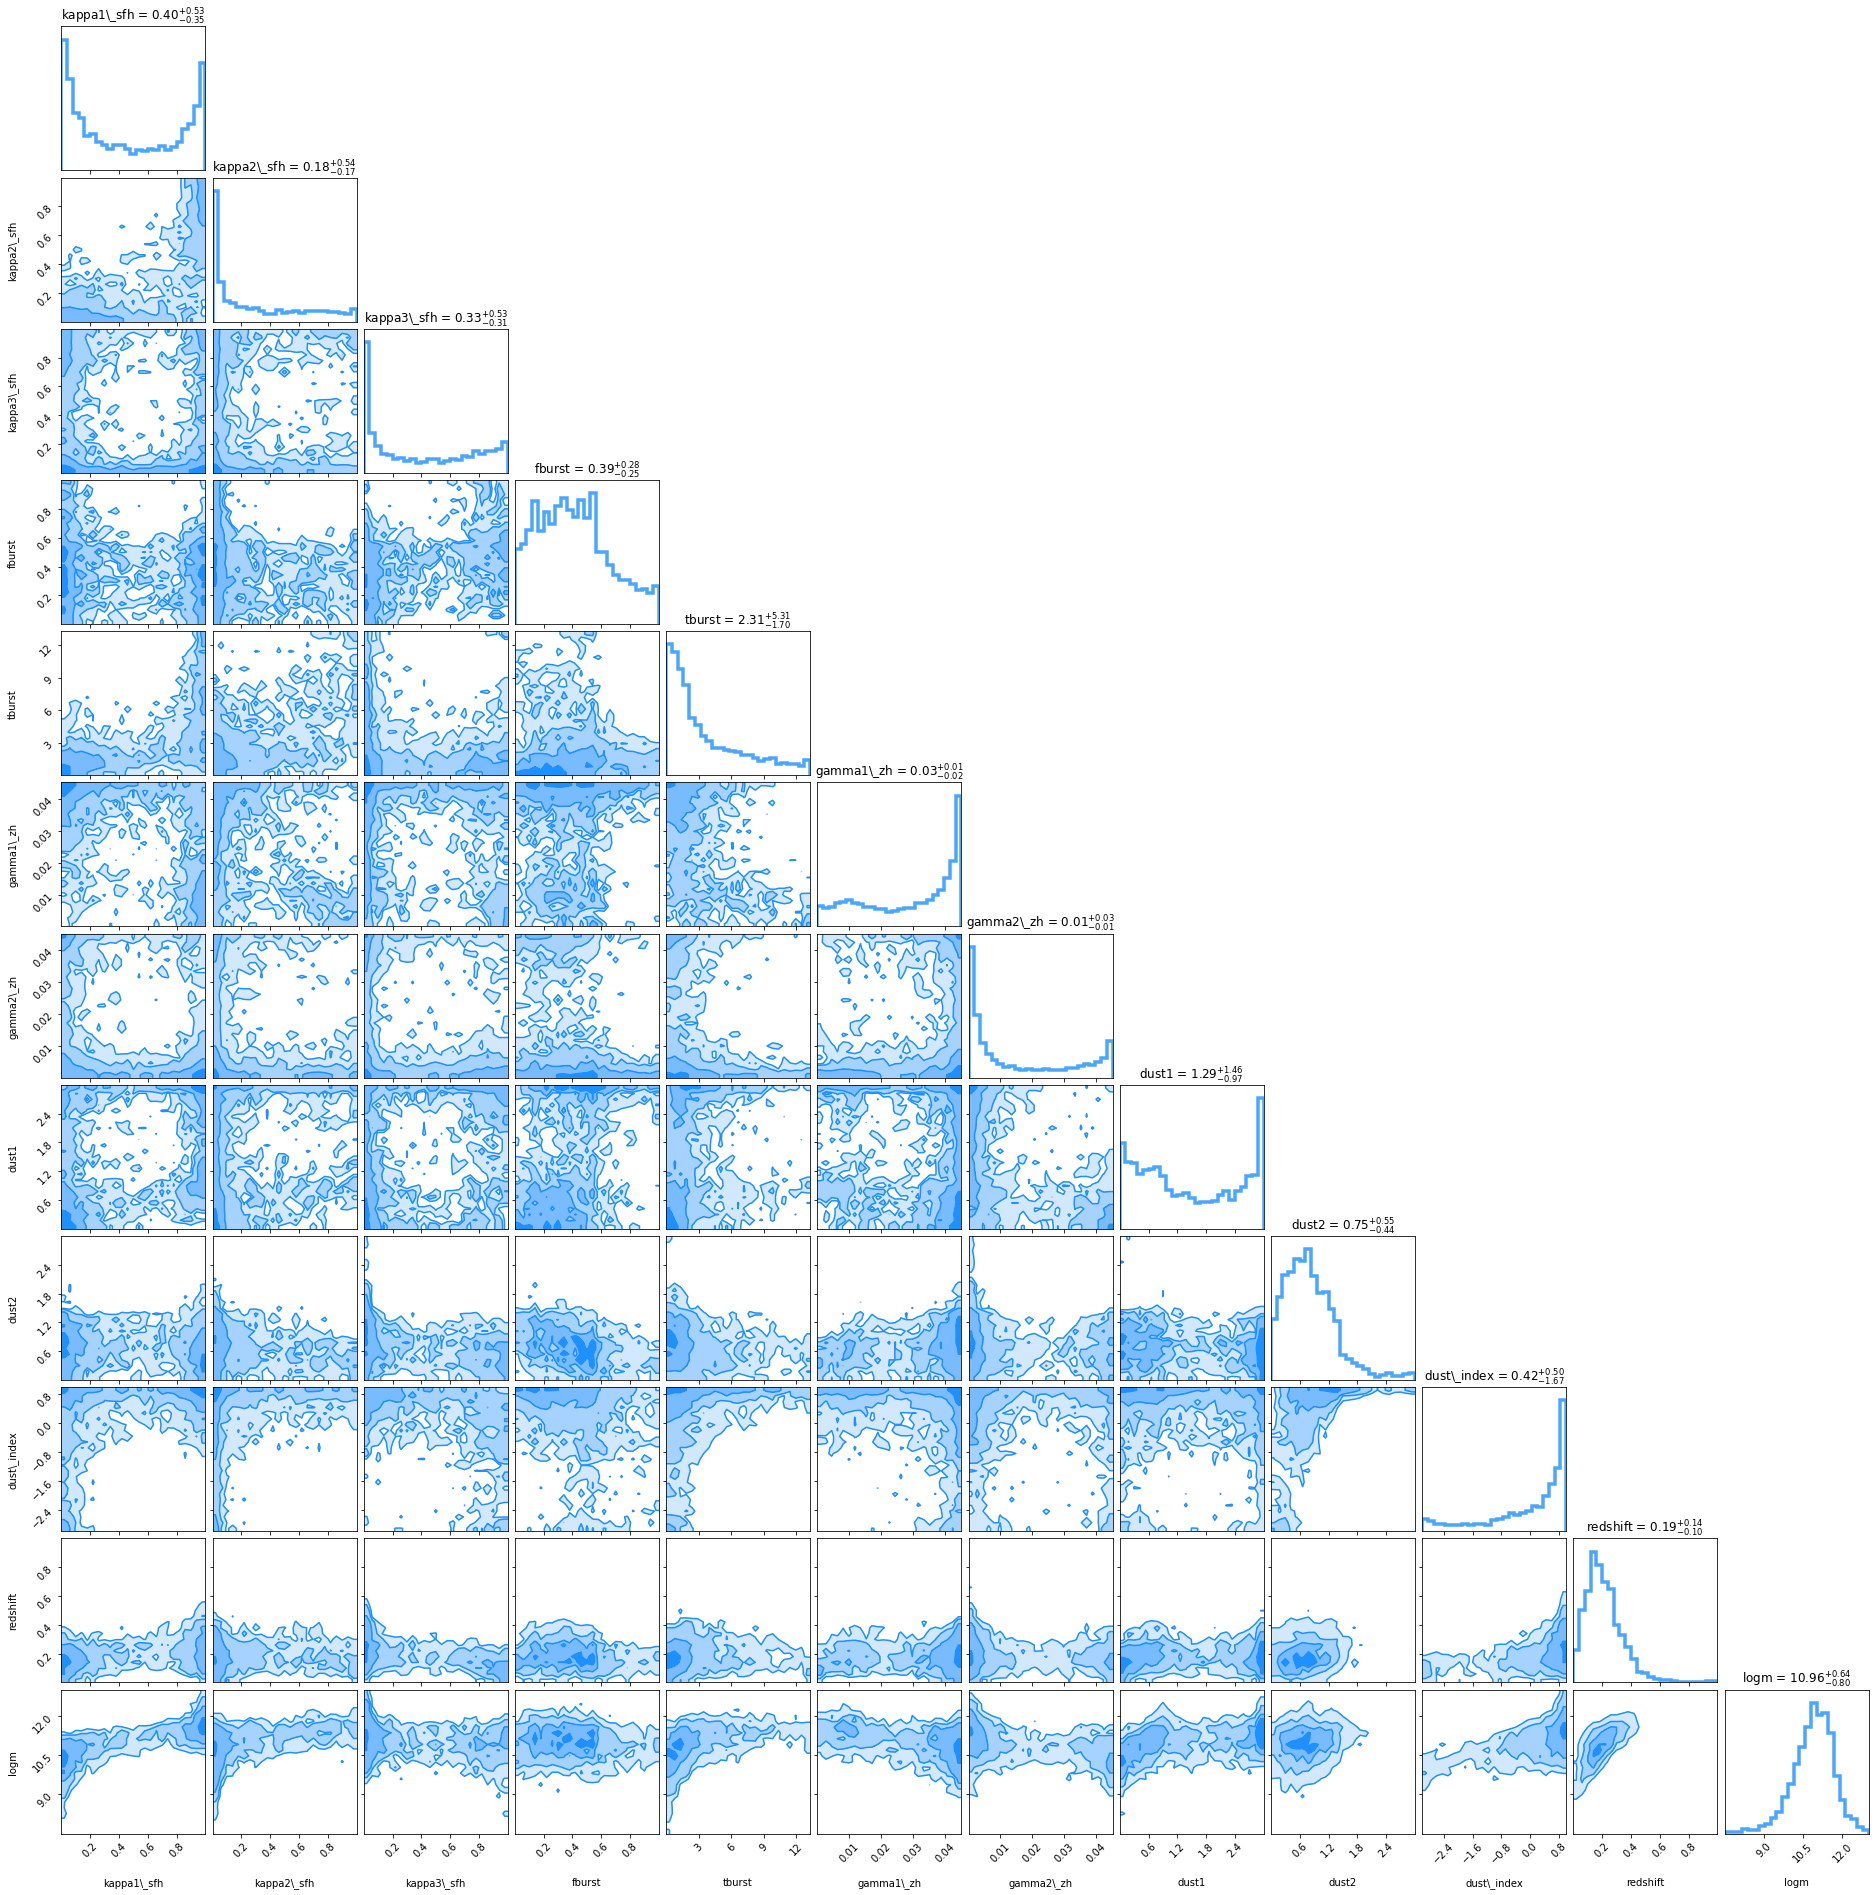

In [60]:
_labels = [f'kappa{i}_sfh' for i in range(1,4)] + speculator.params_name[3:]
_labels = [key.replace('_', '\_') for key in _labels]

nf_plot = corner.corner(_samples_unt, 
                  labels=_labels, bins=25,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.4, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True}, plot_datapoints=False)

# ax = nf_plot.get_axes()[1]
# ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))